# Project 2 - ASL Recognition using Canny Edge and KNN

## Step 0: Install dependencies and libraries

In [ ]:
%pip install --upgrade opencv-python tqdm scikit-image pandas \
    numpy matplotlib keras tensorflow scikit-learn seaborn

In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage import exposure, data
import matplotlib.pyplot as plt
import os.path
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

/Users/thomaskahessay/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Step 1: Upload Dataset

In [2]:
TRAIN_DIR = "asl_alphabet_train/asl_alphabet_train/"
TEST_DIR = "asl_alphabet_test/asl_alphabet_test/"

In [3]:
def load_data(directory, num_of_images=1000):
    images = []
    labels = []

    # Iterate through each image in each subfolder
    for folder in os.listdir(directory):
        count = 0
        for image in os.listdir(directory + "/" + folder):
            count += 1
            temp_img = cv.imread(directory + '/' + folder + '/' + image)
            
            if temp_img is None:
                continue

            images.append(temp_img)
            labels.append(folder)
            if count == num_of_images:
                break

    # Convert to a numpy array
    images = np.array(images)

    # # Normalize the images
    # images = images.astype('float32')/255.0
    
    return images, labels

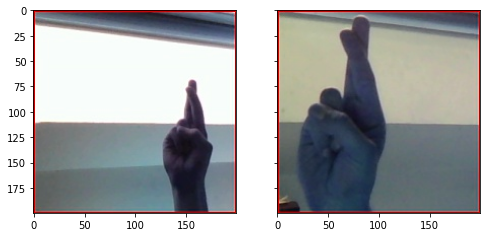

In [6]:
X_train, y_train = load_data(TRAIN_DIR)
X_test, y_test = load_data(TEST_DIR, 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.imshow(X_train[0], cmap=plt.cm.gray)
ax2.imshow(X_test[0], cmap=plt.cm.gray)
plt.show()

## Step 2: Image Preprocessing

In [8]:
processed_train_images = []
processed_test_images = []

for image in X_train:
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (3, 3), 0)
    processed_train_images.append(blurred)

for image in X_test:
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (3, 3), 0)
    processed_test_images.append(blurred)

## Step 3: Otsu Segmentation

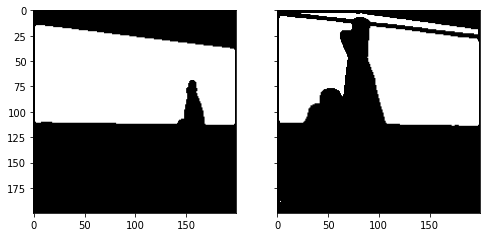

In [9]:
segmented_train_images = []
segmented_test_images = []

for image in processed_train_images:
    otsu_threshold, image_result = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    segmented_train_images.append(image_result)

for image in processed_test_images:
    otsu_threshold, image_result = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    segmented_test_images.append(image_result)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
otsu_train_image_rescaled = exposure.rescale_intensity(segmented_train_images[0], in_range=(0, 10))
otsu_test_image_rescaled = exposure.rescale_intensity(segmented_test_images[0], in_range=(0, 10))
ax1.imshow(otsu_train_image_rescaled, cmap=plt.cm.gray)
ax2.imshow(otsu_test_image_rescaled, cmap=plt.cm.gray)
plt.show()

## Step 4: Feature Extraction (Canny Edge & HOG)

### Canny Edge Detection

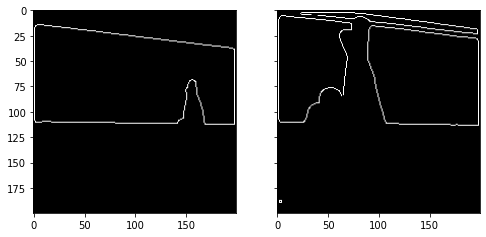

In [10]:
def canny_edge(image, sigma=0.33):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv.Canny(image, lower, upper)
    return edged

canny_edge_train_images = []
canny_edge_test_images = []

for image in segmented_train_images: 
    auto = canny_edge(image)
    canny_edge_train_images.append(auto)

for image in segmented_test_images:
    auto = canny_edge(image)
    canny_edge_test_images.append(auto)

# wide = cv.Canny(image_result, 10, 200)
# tight = cv.Canny(image_result, 225, 250)
# auto = canny_edge(image_result)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# wide_image_rescaled = exposure.rescale_intensity(wide, in_range=(0, 10))
# tight_image_rescaled = exposure.rescale_intensity(tight, in_range=(0, 10))
auto_train_image_rescaled = exposure.rescale_intensity(canny_edge_train_images[0], in_range=(0, 10))
auto_test_image_rescaled = exposure.rescale_intensity(canny_edge_test_images[0], in_range=(0, 10))

# ax1.imshow(wide_image_rescaled, cmap=plt.cm.gray)
# ax2.imshow(tight_image_rescaled, cmap=plt.cm.gray)
ax1.imshow(auto_train_image_rescaled, cmap=plt.cm.gray)
ax2.imshow(auto_test_image_rescaled, cmap=plt.cm.gray)
plt.show()

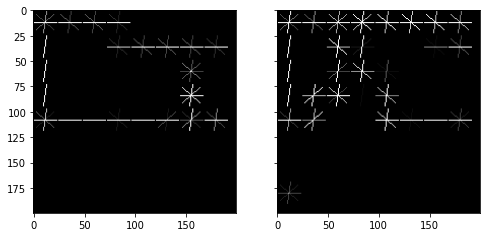

In [11]:
# im = np.float32(auto) / 255.0
# gx = cv.Sobel(im, cv.CV_32F, 1, 0, ksize=3)
# gy = cv.Sobel(im, cv.CV_32F, 0, 1, ksize=3)

# mag, angle = cv.cartToPolar(gx, gy, angleInDegrees=True)
# print(map, angle)

hog_train_images = []
hog_train_features = []
hog_test_images = []
hog_test_features = []

for image in canny_edge_train_images:
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(24, 24), cells_per_block=(2, 2), visualize=True, block_norm='L2', feature_vector=True)
    hog_train_images.append(hog_image)
    hog_train_features.append(fd)

for image in canny_edge_test_images:
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(24, 24), cells_per_block=(2, 2), visualize=True, block_norm='L2', feature_vector=True)
    hog_test_images.append(hog_image)
    hog_test_features.append(fd)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
hog_train_image_rescaled = exposure.rescale_intensity(hog_train_images[0], in_range=(0, 10))
hog_test_image_rescaled = exposure.rescale_intensity(hog_test_images[0], in_range=(0, 10))
ax1.imshow(hog_train_image_rescaled, cmap=plt.cm.gray)
ax2.imshow(hog_test_image_rescaled, cmap=plt.cm.gray)
plt.show()

Renaming the variables for ease of use.

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(hog_train_features, y_train, random_state=0, test_size=0.2)
X_test = hog_test_features

## Step 5: Classification (KNN)

In [25]:
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train, y_train)

predictions = clf.predict(X_valid)
print(accuracy_score(y_valid, predictions))

0.9443103448275862
